In [221]:
import sys
import os
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
base_path = '/mywork/PGDDS-IIITB/MyPractice'
proj_dir_path = os.path.join(base_path,"MyMScProj")
dataset_base_path = '/mywork/PGDDS-IIITB/MyDatasets'

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

sys.path.append(base_path)
sys.path.append(proj_dir_path)

import tensorflow as tf


In [222]:
import numpy as np
from tensorflow.keras.models import load_model
from MyMScProj.jmod.utils import load_image_and_convert_scaled_pixels
from MyMScProj.jmod.onestage.yolov3.bbox import AnchorBox
#from MyMScProj.jmod.onestage.yolov3.inference import decode_yolo_netout, correct_yolo_boxes, draw_boxes
from MyMScProj.jmod.onestage.yolov3.inference import preprocess_input
from MyMScProj.jmod.utils import sigmoid, softmax
from MyMScProj.jmod.onestage.yolov3.bbox import BoundingBox
from matplotlib import pyplot
from matplotlib.patches import Rectangle

In [2221]:
anchors=np.array([43,23,
 285,205,
 478,273,
 229,132,
 42,49,
 107,67,
 77,39,
 23,15,
 11,8])
ignore_thresh = 0.3
input_w, input_h = 416, 416
num_classes=11
batch_size=50
grid_scales=[1,1,1]
max_grid = [416, 416]
obj_scale = 5
noobj_scale = 1
xywh_scale = 1
class_scale = 1
warmup_batches = 1
max_box_per_image=34
#saved_model_path=os.path.join(proj_dir_path,'jmod/onestage/yolov3/jm_yolo3_tst1.h5')
#saved_model_path=os.path.join(proj_dir_path,'jmod/onestage/yolov3/jm_yolo3_tst1_1stworkingmodel.h5')
#saved_model_path=os.path.join(proj_dir_path,'jmod/onestage/yolov3/jm_yolo3_tst3.h5')
#saved_model_path=os.path.join(proj_dir_path,'jmod/onestage/yolov3/jm_yolo3_tst5.h5')
saved_model_path=os.path.join(proj_dir_path,'jmod/onestage/yolov3/jm_yolo3_tst6.h5')
#saved_model_path=os.path.join(proj_dir_path,'jmod/onestage/yolov3/jm_yolo3_tst3_WIP.h5')


labels = ['articulated_truck', 'bicycle', 'bus', 'car',
           'motorcycle', 'motorized_vehicle', 'non-motorized_vehicle',
           'pedestrian', 'pickup_truck', 'single_unit_truck', 'work_van']
test_img_dir = os.path.join(dataset_base_path,"MIO-TCD/MIO-TCD-Localization/test")


In [2222]:
infer_model=load_model(saved_model_path, compile=False)  # default is True
print(infer_model.summary())

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
conv_0 (Conv2D)                 (None, 416, 416, 32) 864         image_input[0][0]                
__________________________________________________________________________________________________
bnorm_0 (BatchNormalization)    (None, 416, 416, 32) 128         conv_0[0][0]                     
__________________________________________________________________________________________________
leaky_0 (LeakyReLU)             (None, 416, 416, 32) 0           bnorm_0[0][0]                    
_______________________________________________________________________________________

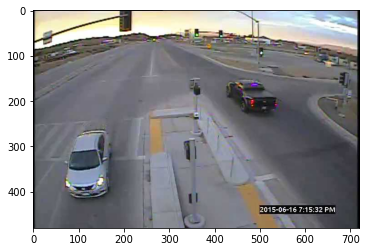

In [2383]:
from keras import backend as K
import tensorflow as tf

K.clear_session()
import cv2
import matplotlib.pyplot as plt

filename=os.path.join(test_img_dir,'00138488.jpg')
#filename=os.path.join(test_img_dir,'00137741.jpg')
#filename=os.path.join(test_img_dir,'00137757.jpg') # busy evening with lots of cars in parking lot, and bus
#filename=os.path.join(test_img_dir,'00137833.jpg') # multiple trucks
#filename=os.path.join(test_img_dir,'00127972.jpg')
#filename=os.path.join(test_img_dir,'00127980.jpg')
#filename=os.path.join(test_img_dir,'00128345.jpg')
#filename=os.path.join(test_img_dir,'00138110.jpg') # road side offie parking lot
#filename=os.path.join(test_img_dir,'00136312.jpg') # prominent single white car as motorized vehicle
#filename=os.path.join(test_img_dir,'00136078.jpg') # person, car, bus
#filename=os.path.join(test_img_dir,'00136028.jpg') # variety of car, truck, trolly
#filename=os.path.join(test_img_dir, '00138078.jpg')
#filename=os.path.join(test_img_dir, '00137980.jpg') # bicycle
#filename=os.path.join(test_img_dir, '00137384.jpg') # city road plus human
#filename=os.path.join(test_img_dir, '00137860.jpg') # city road with parking lot vehicles
#filename=os.path.join(test_img_dir, '00137742.jpg') # small size image
#filename=os.path.join(test_img_dir, '00137860.jpg') 
#filename=os.path.join(test_img_dir, '00137734.jpg') # night bus
#filename=os.path.join(test_img_dir, '00136996.jpg') # human, bicycle
#filename=os.path.join(test_img_dir, '00136658.jpg') # small size image with lots of vehicle
#image, image_w, image_h = load_image_and_convert_scaled_pixels(filename,input_w, input_h)

# see image before detection
img_plt = cv2.imread(filename)
img_plt = cv2.cvtColor(img_plt, cv2.COLOR_BGR2RGB)
image_w, image_h, _ = img_plt.shape
image = preprocess_input(img_plt, input_w, input_h)
plt.subplot(1, 1, 1)
plt.imshow(img_plt)
plt.show()

In [2361]:
os.path.basename(filename)

'00136996.jpg'

In [2384]:

yolo_out = infer_model.predict(image)
print([a.shape for a in yolo_out])

[(1, 13, 13, 48), (1, 26, 26, 48), (1, 52, 52, 48)]


In [2385]:
from MyMScProj.jmod.onestage.yolov3.inference import decode_yolo_netout
boxes = list()
ignore_thresh=0.4
boxes += decode_yolo_netout(yolo_out[0][0], anchors[12:], ignore_thresh, input_h, input_w)
boxes += decode_yolo_netout(yolo_out[1][0], anchors[6:12], ignore_thresh, input_h, input_w)
boxes += decode_yolo_netout(yolo_out[2][0], anchors[:6], ignore_thresh, input_h, input_w)

In [2386]:
def find_high_class_probability_bbox(netout_scale, obj_thresh):
    grid_h, grid_w = netout_scale.shape[:2]
    nb_box=3
    netout_scale = netout_scale.reshape((grid_h, grid_w, nb_box, -1))
    
    boxes = []
    for row in range(grid_h):
        for col in range(grid_w):
            for b in range(nb_box):
                # from 4th element onwards are confidence and class classes
                classes = netout_scale[row][col][b][5:]
                if np.sum(classes) > 0:
                    # first 4 elements are x, y, w, and h
                    x, y, w, h = netout_scale[row][col][b][:4]
                    confidence = netout_scale[row][col][b][4]
                    box = BoundingBox(x, y, w, h, confidence, classes)
                    if box.get_score() > obj_thresh:
                        boxes.append([x,y,w,h,confidence,classes])
    return(boxes)


In [2387]:
def print_decoded_yolo_netout_res(netout, ignore_thresh, boxes ):
    grid_h, grid_w = netout.shape[:2]
    nb_box = 3
    thres_boxes=boxes
    print("Grid Scale {}x{}".format(grid_h,grid_w ))
    print("YOLO produces GRID_H * GRID_W * BOX = {} bounding boxes \
        ".format( grid_h * grid_w * nb_box))    
    print("found {} bounding boxes with top class probability > {}".format(len(thres_boxes),ignore_thresh))
    print("")



In [2396]:
object_thres=0.3
scale13x_preds = find_high_class_probability_bbox(yolo_out[0][0], object_thres)
print_decoded_yolo_netout_res(yolo_out[0][0], object_thres, scale13x_preds)

scale26x_preds = find_high_class_probability_bbox(yolo_out[1][0], object_thres)
print_decoded_yolo_netout_res(yolo_out[1][0], object_thres, scale26x_preds)

scale52x_preds = find_high_class_probability_bbox(yolo_out[2][0], object_thres)
print_decoded_yolo_netout_res(yolo_out[2][0], object_thres, scale52x_preds)

Grid Scale 13x13
YOLO produces GRID_H * GRID_W * BOX = 507 bounding boxes         
found 1 bounding boxes with top class probability > 0.3

Grid Scale 26x26
YOLO produces GRID_H * GRID_W * BOX = 2028 bounding boxes         
found 4 bounding boxes with top class probability > 0.3

Grid Scale 52x52
YOLO produces GRID_H * GRID_W * BOX = 8112 bounding boxes         
found 0 bounding boxes with top class probability > 0.3



In [2397]:
preds=list()
preds = scale13x_preds + scale26x_preds + scale52x_preds

In [2398]:
len(preds)

5

In [2399]:
pred_class_index=0
cnt=1
topNClassIndex=[]
for i in range(len(preds)):
    tmp_index = np.argmax(preds[i][5])
    if tmp_index != pred_class_index:        
        pred_class_index = tmp_index
        if pred_class_index not in topNClassIndex:            
            topNClassIndex.append(pred_class_index)
            print("predicted class: Pr(Class={:20} [index={}])={:5.3f}".format(labels[pred_class_index],
                                                                                    pred_class_index,
                                                                                    preds[i][5][tmp_index]) )


            
print(topNClassIndex)


predicted class: Pr(Class=car                  [index=3])=0.438
[3]


In [24]:
infer_model.inputs

[<tf.Tensor 'image_input:0' shape=(?, 416, 416, 3) dtype=float32>]

In [88]:
infer_model.output

[<tf.Tensor 'conv_81/BiasAdd:0' shape=(?, 13, 13, 48) dtype=float32>,
 <tf.Tensor 'conv_93/BiasAdd:0' shape=(?, 26, 26, 48) dtype=float32>,
 <tf.Tensor 'conv_105/BiasAdd:0' shape=(?, 52, 52, 48) dtype=float32>]

In [1650]:
from keras import models
from keras.layers import Input

In [2400]:
from keras import models
layer_name='conv_80'
#layer_name='conv_92'
#layer_name='conv_104'
last_conv_layer = infer_model.get_layer(layer_name)
last_conv_output = last_conv_layer.output
last_conv_layer_model = models.Model(infer_model.inputs, last_conv_output)
last_conv_layer_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
conv_0 (Conv2D)                 (None, 416, 416, 32) 864         image_input[0][0]                
__________________________________________________________________________________________________
bnorm_0 (BatchNormalization)    (None, 416, 416, 32) 128         conv_0[0][0]                     
__________________________________________________________________________________________________
leaky_0 (LeakyReLU)             (None, 416, 416, 32) 0           bnorm_0[0][0]                    
_______________________________________________________________________________________

In [2401]:
last_conv_layer_model.output

<tf.Tensor 'conv_80/Conv2D:0' shape=(None, 13, 13, 1024) dtype=float32>

In [2402]:
last_conv_layer_model.output[...,3]

<tf.Tensor 'strided_slice_1:0' shape=(None, 13, 13) dtype=float32>

In [2403]:
last_conv_layer_name = infer_model.get_layer(layer_name).name
last_conv_layer_scale = infer_model.get_layer(layer_name).get_output_at(0).get_shape()[1]
last_conv_layerNameScale = str(last_conv_layer_name) + "_scale" + str(last_conv_layer_scale) + "x"
print(last_conv_layerNameScale)


conv_80_scale13x


In [2237]:
#last_conv92_layer_model.summary()

In [2238]:
layer_input = last_conv_layer_model.input
layer_input

<tf.Tensor 'image_input:0' shape=(None, 416, 416, 3) dtype=float32>

In [2239]:
image.shape

(1, 416, 416, 3)

In [2240]:
#### one more diferent attempt 
## as per https://github.com/jacobgil/keras-grad-cam


In [2241]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Flatten, Dense, Conv2D
from tensorflow.keras.layers import GlobalAveragePooling1D
from keras.layers.merge import add, concatenate
from tensorflow.keras import models

In [2242]:
def target_category_loss(x, category_index, nb_classes):
    #return tf.multiply(x, K.one_hot([category_index], nb_classes))
    return tf.multiply(x, K.one_hot(category_index, nb_classes))

def target_category_loss_output_shape(input_shape):
    return input_shape

def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

In [2243]:
tf_image = tf.constant(image)
nb_classes=len(labels)
category_index = topNClassIndex
target_layer = lambda x: target_category_loss(x, category_index, nb_classes)

In [2244]:
category_index

[3]

In [2245]:
K.one_hot(category_index, nb_classes)

<tf.Tensor: shape=(1, 11), dtype=float32, numpy=array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>

In [2246]:
print(last_conv_layer_model.input)
print(last_conv_layer_model.output)
print(last_conv_layer_name)

Tensor("image_input:0", shape=(None, 416, 416, 3), dtype=float32)
Tensor("conv_80/Conv2D:0", shape=(None, 13, 13, 1024), dtype=float32)
conv_80


In [2247]:
#last_conv_layer_model.layers

In [2248]:
conv_output =  [l for l in last_conv_layer_model.layers if l.name == last_conv_layer_name][0].output
conv_output

<tf.Tensor 'conv_80/Conv2D:0' shape=(None, 13, 13, 1024) dtype=float32>

In [2249]:
flattenConv=Conv2D(11, 1, activation='linear')(last_conv_layer_model.output)
flat = Flatten()(flattenConv)
#maxPool = MaxPooling2D()(last_conv_layer_model.output)
#avgPool = AveragePooling2D()(last_conv_layer_model.output)
#globalAvgPool = GlobalAveragePooling2D()(last_conv_layer_model.output)
#flat = Flatten()(globalAvgPool)
#fc = Dense(11, activation='linear')(flat)
fc = Dense(11, activation='softmax')(flat)
#fc = Dense(11, activation='relu')(flat)
lambda_layer_last = Lambda(target_layer, output_shape = target_category_loss_output_shape)(fc)
grad_model = models.Model(inputs=last_conv_layer_model.input, outputs=[conv_output, lambda_layer_last])
grad_model.summary()


Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
conv_0 (Conv2D)                 (None, 416, 416, 32) 864         image_input[0][0]                
__________________________________________________________________________________________________
bnorm_0 (BatchNormalization)    (None, 416, 416, 32) 128         conv_0[0][0]                     
__________________________________________________________________________________________________
leaky_0 (LeakyReLU)             (None, 416, 416, 32) 0           bnorm_0[0][0]                    
_______________________________________________________________________________________

In [2250]:
#tf_image
grad_model.layers[-1]

In [2251]:
lambda_layer_last

<tf.Tensor 'lambda/Mul:0' shape=(None, 11) dtype=float32>

In [2252]:
grad_model.input

<tf.Tensor 'image_input:0' shape=(None, 416, 416, 3) dtype=float32>

In [2253]:
#conv_outputs,predictions = grad_model(tf_image)
#print(predictions[:,np.argmax(preds[0][5])])
#print(tf.reduce_mean(predictions))

In [2254]:
with tf.GradientTape() as tape:    
    tape.watch(tf_image)    
    conv_outputs,predictions = grad_model(tf_image)
    #loss = K.sum(predictions)
    #loss=tf.reduce_mean(predictions[:,np.argmax(preds[1][5])])
    #loss = K.sum(predictions[:,np.argmax(preds[0][5])])
    loss=tf.reduce_mean(predictions)
    #loss = predictions[:,np.argmax(preds[0][5])]
    

In [2255]:
#tape

In [2256]:
predictions
#predictions[:,3]

<tf.Tensor: shape=(1, 11), dtype=float32, numpy=
array([[0.        , 0.        , 0.        , 0.00077964, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ]], dtype=float32)>

In [2257]:
#loss

In [2258]:
#conv_outputs

In [2259]:
#grads = normalize(tape.gradient(loss, conv_outputs))
grads = tape.gradient(loss, conv_outputs)

In [2175]:
#rads

In [2176]:
#pooled_grads=K.mean(grads, axis=(0,1,2))

In [2177]:
#pooled_grads
#grads.numpy()[0]

In [2178]:
# conv_layer_output_val = grads.numpy()[0]
# print(conv_layer_output_val.shape)
# pooled_grads_val = pooled_grads.numpy()
# print(pooled_grads_val.shape)

In [2179]:
#pooled_grads_val.shape[-1]

In [2180]:
# for i in range(pooled_grads_val.shape[-1]):
#     conv_layer_output_val[:, :, i] *= pooled_grads_val[i]

In [2181]:
# conv_layer_output_val.shape

In [2260]:
# compute the guided gradients
# https://www.pyimagesearch.com/2020/03/09/grad-cam-visualize-class-activation-maps-with-keras-tensorflow-and-deep-learning/
castConvOutputs = tf.cast(conv_outputs > 0, "float32")
castGrads = tf.cast(grads > 0, "float32")
guidedGrads = castConvOutputs * castGrads * grads

In [2261]:
guidedGrads.shape

TensorShape([1, 13, 13, 1024])

In [2262]:
# the convolution and guided gradients have a batch dimension
# (which we don't need) so let's grab the volume itself and
# discard the batch
convOutputs = conv_outputs[0]
guidedGrads = guidedGrads[0]

In [2263]:
# compute the average of the gradient values, and using them
# as weights, compute the ponderation of the filters with
# respect to the weights
weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

In [2264]:
img_plt.shape

(480, 720, 3)

In [2265]:
# grab the spatial dimensions of the input image and resize
# the output class activation map to match the input image
# dimensions
#(w, h) = (image.shape[2], image.shape[1])
(w, h) = (img_plt.shape[1], img_plt.shape[0])
heatmap = cv2.resize(cam.numpy(), (w, h))

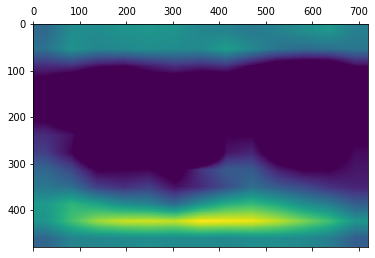

In [2266]:
#heatmap = np.mean(conv_layer_output_val, axis=-1)

# normalize heatmap for visualization
heatmap=np.maximum(heatmap,0)
heatmap /= np.max(heatmap)

plt.matshow(heatmap)
plt.show()

In [2267]:
print(heatmap.shape)
print(img_plt.shape)

(480, 720)
(480, 720, 3)


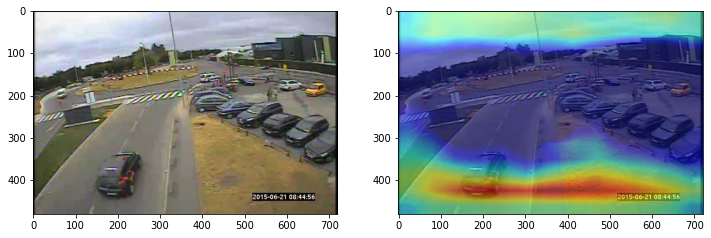

In [2268]:
fig, axes = plt.subplots(1,2,figsize=(12,6))
axes[0].imshow(img_plt)
axes[1].imshow(img_plt)
axes[1].imshow(heatmap,cmap="jet",alpha=0.5)
#i = axes[1].imshow(heatmap,cmap="jet",alpha=0.4)
#fig.colorbar(i)
#plt.imshow()
#plt.title('Explanation for `{}`'.format(labels[category_index]))
plt.show()

In [2269]:
import cv2
cv2_img=cv2.imread(filename)
cv2_heatmap=cv2.resize(heatmap, dsize=(cv2_img.shape[1],cv2_img.shape[0]))
# convert the heatmap to rgb
cv2_heatmap=np.uint8(255*cv2_heatmap)
cv2_heatmap=cv2.applyColorMap(cv2_heatmap, cv2.COLORMAP_JET)
#cv2_heatmap=cv2.applyColorMap(cv2_heatmap, cv2.COLORMAP_AUTUMN)
superimposed_img=cv2_heatmap * 0.5 + cv2_img
cv2.imwrite('/tmp/gc_02v2-' + last_conv_layerNameScale + "-" + os.path.basename(filename),superimposed_img)
#cv2.imshow('/tmp/yolo01_gc.jpg',superimposed_img)

True